# This coding is about:
* How interest rate affects the life of mortgage
* How interest rate affects mortgage servicing rights(MSR)
* How to do MSR hedging

In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# To see plots in notebook, run the following command
%matplotlib inline

In [80]:
# give a basic mortgage case here:
yearRate=0.055
monthRate=yearRate/12
initialLoan=100000
lenthByYear=30
lengthByMonth=360

In [8]:
# define a function to caculate monthly payment
# this is just a mathmatical formula
def caculatePmt(pv,rate,n): 
    pmt=pv*(rate*(1+rate)**n)/((1+rate)**n-1)
    return round(pmt,4)

In [81]:
# calculate how much should be paid every month for this mortgage
scheduledMonthPay=caculatePmt(initialLoan,monthRate,lengthByMonth)

In [10]:
print(scheduledMonthPay) # check the value is correct

567.789

# Prepayment model
One of the most popular prepayment model is PSA. In this case, I would combine PSA with a model suggested by Office of Thrift Supervision (OTS). The OTS model  considers the refinancing incentive at different rates

Text(0, 0.5, 'prepayment rate')

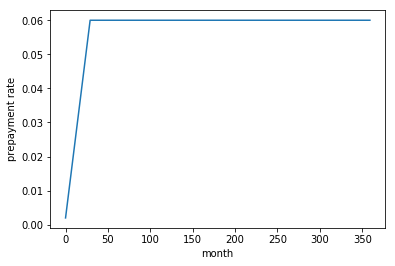

In [15]:
# create PSA prepayment model
# PSA100: increase 0.2% for the first 30 months, and then keep 6%
part1=[0.002 * i for i in range(1,31)]
part2=[0.06 for i in range(1,331)]
PSA100=part1+part2
plt.plot(PSA100)
plt.xlabel('month')
plt.ylabel('prepayment rate')

In [20]:
# define the refinance incentive function
# the following function comes from model proposed by OTS
def refinanceIncentive(myMtgRate,currentMtgRate):
    refiIncentive=3*(0.2406-0.1389*np.arctan(5.952*(1.089-myMtgRate/currentMtgRate)))
    return round(refiIncentive,4)

Text(0, 0.5, 'refinancing incentive')

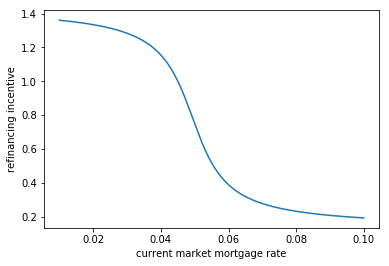

In [23]:
# plot the figure of incentive functions
x=np.arange(0.01,0.1,0.0005)
y=[refinanceIncentive(0.055,i) for i in x] # 0.055 is the rate of my mortgage
plt.plot(x,y)
plt.xlabel('current market mortgage rate')
plt.ylabel('refinancing incentive')

fromt the figure we can see that when mortgage goes very low, the incentive to refinance go very high, and vice verse.

In [61]:
# define the function for Conditional Prepayment Rate (CPR)
# CPR=refiIncentive * PSA100; from CPR, we can get SMM
def CPR(incentive,psa):
    return round(incentive * psa,4)

def SMM(cpr):
    return round(1-(1-cpr)**(1/12),4)

# Interest
As the prepayment is related to interest rate, so here I will create a interest rate binomial tree, which can be used to evalute the prepayment speed

In [46]:
# define a function to generate interest binomial tree. 360*360 size
def generateInterestTree(initialRate,size=360,volotility=0.01):
    interestTree=np.zeros((size,size))
    interestTree[0,0]=initialRate
    for y in range(1,size):
        for x in range(0,y):
            interestTree[x,y]=round(interestTree[x,y-1]*math.exp(volotility),4)
        interestTree[y,y]=round(interestTree[y-1,y-1]/math.exp(volotility),4)
    return interestTree
    

In [39]:
def generateDicountTree(interestTree,size=360): # dicount tree, 360*360 size
    monthDiscount=np.zeros((size,size))
    for x in range(0,size):
        for y in range(x,360):
            monthDiscount[x,y]=1/(1+interestTree[x,y])
    return monthDiscount

In [36]:
interestTree=generateInterestTree(0.002)

In [37]:
print(interestTree)

[[2.00000000e-03 2.02010033e-03 2.04040268e-03 ... 7.10331863e-02
  7.17470817e-02 7.24681519e-02]
 [0.00000000e+00 1.98009967e-03 2.00000000e-03 ... 6.96266350e-02
  7.03263943e-02 7.10331863e-02]
 [0.00000000e+00 0.00000000e+00 1.96039735e-03 ... 6.82479352e-02
  6.89338384e-02 6.96266350e-02]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.63117074e-05
  5.68776494e-05 5.74492793e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.57513965e-05 5.63117074e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.51966608e-05]]


In [165]:
dicountTree=generateDicountTree(interestTree)
print(dicountTree)

[[0.99009901 0.99000099 0.98990299 ... 0.75233223 0.75046904 0.74861506]
 [0.         0.99019705 0.99009901 ... 0.75602933 0.75420469 0.75233223]
 [0.         0.         0.99029511 ... 0.75970523 0.75786283 0.75602933]
 ...
 [0.         0.         0.         ... 0.99502488 0.99492588 0.9948269 ]
 [0.         0.         0.         ... 0.         0.99502488 0.99492588]
 [0.         0.         0.         ... 0.         0.         0.99502488]]


In [132]:
# generate interest path
def generateIntPath():
    np.random.seed(5)# generate same random, useto do test
    masks=[np.random.random()>0.5 for i in range(0,359)]
    x,y=0,0
    interestPath=[]
    interestPath.append(interestTree[0,0])
    for i in range(len(masks)):
        y+=1
        if masks[i]==False:
            x+=1
        interestPath.append(interestTree[x,y])
    return interestPath

In [69]:
# based on the interest path, get the CPR 
def generateCPR_SMM(interestPath):
    cprList=[]
    smmList=[]
    for i in range(0,360):
        psa=PSA100[i]
        annualRate=(interestPath[i]+1)**12-1
        # here, assume current mortage is 3% higher,
        # a better way is mortgageRate=0.024+ 0.2 *twoYearRate+0.6*tenYearRate
        currentMortgageRate=annualRate+0.03 
        incentive=refinanceIncentive(0.055,currentMortgageRate)    
        cpr=CPR(incentive,psa)
        smm=SMM(cpr)
        cprList.append(cpr)
        smmList.append(smm)
    return cprList,smmList

In [173]:
def generateDiscountPath(interestPath):
    path=[]
    for i in interestPath:
        path.append(1/(1+i))
    return path

In [178]:
interestPath=generateIntPath()
discountPath=generateDiscountPath(interestPath)

In [ ]:
discountPath

In [71]:
cprList,smmList=generateCPR_SMM(interestPath)

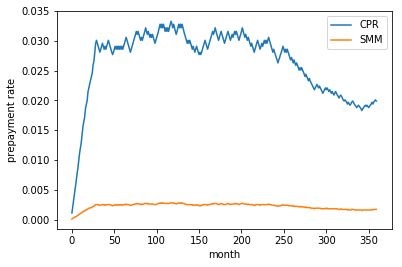

In [92]:
plt.plot(cprList,label='CPR')
plt.plot(smmList,label='SMM')
plt.xlabel('month')
plt.ylabel('prepayment rate')
plt.legend()

# Prepayment and actual term

In [180]:
# define a funciton about mortgagePrepay
def mortgagePrepay(initialLoan,monthRate,scheduledMonthPay,discountPath,smmList):
    interestPaidList=[]
    prepaymentList=[]
    schedulePrinciplePayList=[]
    paidoff=False
    unpaidPrinciple=initialLoan
    mortgageValue=0
    for i in range(0,360):
        dicountFactor= np.prod(dicountPath[0:i+1])
        interestPay=unpaidPrinciple*monthRate
        schedulePrinciplePay=scheduledMonthPay-interestPay
        if schedulePrinciplePay>=unpaidPrinciple: 
            schedulePrinciplePay=unpaidPrinciple
            unpaidPrinciple=0
            #print('all principle paid') # if all paid
            paidoff=True
        else:
            prepayment=(unpaidPrinciple-schedulePrinciplePay)*smmList[i]
            if prepayment>=unpaidPrinciple-schedulePrinciplePay: # if prepayment > remaining principle
                prepayment=unpaidPrinciple-schedulePrinciplePay
                unpaidPrinciple=0
                #print('i is, ',i)
                paidoff=True
            else:
                unpaidPrinciple=unpaidPrinciple-schedulePrinciplePay-prepayment
                #print('unpaid principle is, ',unpaidPrinciple)
        paymentPV=(prepayment+scheduledMonthPay)*dicountFactor
        #print(dicountFactor)
        mortgageValue+=paymentPV
        interestPaidList.append(interestPay)
        prepaymentList.append(prepayment)
        schedulePrinciplePayList.append(schedulePrinciplePay)
        
        if paidoff==True:
            break
    return i,mortgageValue,interestPaidList,prepaymentList,schedulePrinciplePayList

In [ ]:
results=mortgagePrepay(initialLoan,monthRate,scheduledMonthPay,discountPath,smmList)

In [182]:
 #return i,interestPaidList,prepaymentList,unpaidPrincipleList
length,mortgageValue,interestPaidList,prepaymentList,schedulePrinciplePay=results

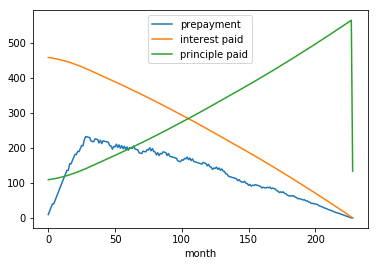

In [124]:
plt.plot(prepaymentList,label='prepayment')
plt.plot(interestPaidList,label='interest paid')
plt.plot(schedulePrinciplePay,label='principle paid')
plt.xlabel('month')
plt.legend()

From the figure, we can see that prepayment increase first,then reduce. This is because after 30 months, the PSA keeps stable, however, the reaming principle drops.

# Mortgage Servicing Rights Hedge

MSR is considered to be interest only (I/O) asset, and it's total value is mostly determined by the life the underlining mortgage. When mortgate rages increase, loan borrowers are less likely to prepay, thus the life of the mortgage will be longer.

In [ ]:
# see the relationship between interest rate and life of mortgage
length=[]
mortgageValue=[]
rateRange=list(np.arange(0.0001,0.01,0.0003))
for r in rateRange:
    interestTree=generateInterestTree(r)
    dicountTree=generateDicountTree(interestTree)
    interestPath=generateIntPath()
    cprList,smmList=generateCPR_SMM(interestPath)
    l,m=mortgagePrepay(initialLoan,monthRate,scheduledMonthPay,dicountTree,smmList)[0:2]
    length.append(l) 
    mortgageValue.append(m)

Text(0, 0.5, 'actual life of mortgage(30 years)')

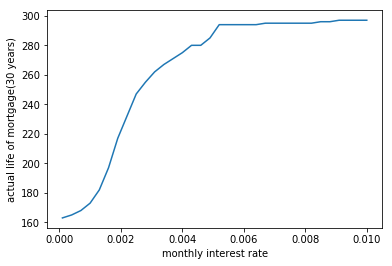

In [148]:
plt.plot(rateRange,length)
plt.xlabel('monthly interest rate')
plt.ylabel('actual life of mortgage(30 years)')

Text(0, 0.5, 'present value of mortgage(30 years)')

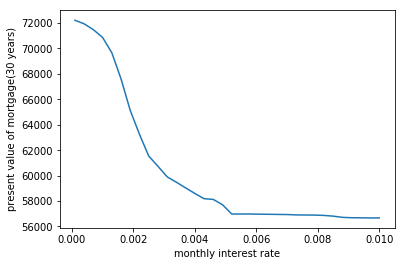

In [186]:
plt.plot(rateRange,mortgageValue)
plt.xlabel('monthly interest rate')
plt.ylabel('present value of mortgage(30 years)')

### Negative convexity: from the figure, we can se that the line has a concave shape.relate it fixed-incomeing securitites, we can say MSR has a negative convexity.

possible hedging choces:
* the asset's value should have a negative correlation with interest rate
* the asset's volatility should be small (the purpose of hedging is to reduce volatility)
* positive convexity with interest rate will be ideal

## choice 1. swap
 for example a 5 year term swap
 lock a fixed interst rate, and give out LIBRO+ 1%
 assume fixed interest =3.5%, total asset equal to 1,000,000

In [158]:
libors=list(np.arange(0.01,0.05,0.01))
gain=[1000000*(3.5/100-1/100-l) for l in libors]

Text(0, 0.5, 'gain from the swap')

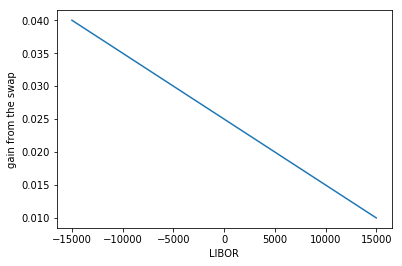

In [159]:
plt.plot(gain,libors)
plt.xlabel('LIBOR')
plt.ylabel('gain from the swap')

so, this swap has a linear relationship with the interest rate, thus it is able to hedge the valolity caused from duration, but not the convexity.

## choice 2: MBS
from the following figure we can see, the value of martage has a perfect negative correlation with MSR, so we can use MBS to as a hedge.

Text(0, 0.5, 'present value of mortgage(30 years)')

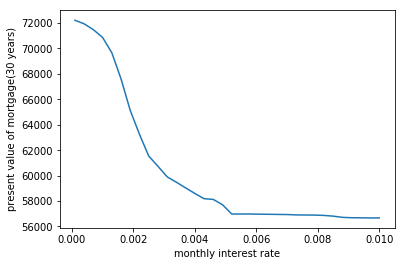

In [187]:
plt.plot(rateRange,mortgageValue)
plt.xlabel('monthly interest rate')
plt.ylabel('present value of mortgage(30 years)')

## choice 3: Treasury : (to continue)